In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from pathlib import Path
from dynamiqs import wigner
import jax.numpy as jnp
import dynamiqs as dq
import scipy as sp

In [2]:
def load_state_from_file(file_path):
    """
    Lädt alle Quantum-State Pickle-Dateien aus dem angegebenen Verzeichnis und visualisiert sie.
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"Lade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            loaded_state = pickle.load(f)
            loaded_state_clean = np.nan_to_num(loaded_state, nan=0.0)
            return loaded_state_clean
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")

In [3]:
def load_noisy_wigner_file(file_path):
    """
    Lädt alle Quantum-State Pickle-Dateien aus dem angegebenen Verzeichnis und visualisiert sie.
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"Lade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            x_grid, p_grid, w_values = pickle.load(f)
            w_values_clean = np.nan_to_num(w_values, nan=0.0)
            return x_grid, p_grid, w_values_clean
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")

In [4]:
def uniform_displacement_sampling(x_grid, p_grid, w_values, n_samples=200, threshold_factor=0.2):
    """
    Performs uniform sampling of the Wigner function.
    
    Parameters:
    -----------
    wigner_fct : tuple
        The Wigner function as a tuple (x_grid, p_grid, w_values)
    n_samples : int
        Number of points to sample
    threshold_factor : float
        Factor for threshold values
        
    Returns:
    --------
    alpha_k : numpy.ndarray
        Complex values of the sampled points
    alpha_k_x : numpy.ndarray
        x-components of the sampled points
    alpha_k_p : numpy.ndarray
        p-components of the sampled points
    """
    # Find the maximum of the Wigner function
    max_value = np.max(np.abs(w_values))
    print(max_value)
    max_pos = np.where(np.abs(w_values) == max_value)
    print(max_pos)

    x_max = x_grid[max_pos[0][0]] 
    p_max = p_grid[max_pos[1][0]]
    print(f"Maximum der Wigner-Funktion: {max_value}")
    print(f"Position des Maximums: x = {x_max}, p = {p_max}")

    # Shift the grid
    x_grid = x_grid - x_max
    p_grid = p_grid - p_max
    wigner_fct_shifted = (x_grid, p_grid, w_values)

    # Find the minimum of the Wigner function
    min_value = np.min(w_values)
    min_pos = np.where(w_values == min_value)  
    x_min = x_grid[min_pos[0][0]] 
    p_min = p_grid[min_pos[1][0]]
    print(f"Minimum der Wigner-Funktion: {min_value}")
    print(f"Position des Minimums: x = {x_min}, p = {p_min}")

    # Define thresholds
    threshold_max = threshold_factor * max_value  
    threshold_min = threshold_factor * min_value - 0.1

    # Create mask for sampling
    mask = (wigner_fct_shifted[2] >= threshold_max) | (wigner_fct_shifted[2] <= threshold_min)
    rows, cols = np.where(mask)
    x_sampled = x_grid[rows]
    p_sampled = p_grid[cols]
    w_sampled = wigner_fct_shifted[2][mask]

    # Uniformes Sampling
    indices = np.random.choice(len(x_sampled), n_samples, replace=False)
    alpha_k_x = x_sampled[indices]
    alpha_k_p = p_sampled[indices]

    print(f"Number of points sampled: {len(alpha_k_x)}")
    
    alpha_k = [(x, p) for x, p in zip(alpha_k_x, alpha_k_p)]
    return alpha_k

In [5]:
def get_center_of_mass(xvals, yvals, wigner):
    wigner_abs_norm = np.abs(wigner) / np.sum(np.abs(wigner))
    center_of_mass = np.array([0,0])
    for xi, yi in np.ndindex(len(xvals), len(yvals)):
        vector = np.array([xvals[xi], yvals[yi]])
        center_of_mass = center_of_mass + wigner_abs_norm[xi, yi] * vector
    
    return center_of_mass

In [6]:
def threshold_sampling(xvals, yvals, wigner, n_samples=200, threshold=0.2):
    thresholded_idxs = []
    wigner_abs = np.abs(wigner)

    for xi, yi in np.ndindex(len(xvals), len(yvals)): 
        if wigner_abs[xi, yi] > threshold:
            thresholded_idxs += [(xi,yi)]

    rand_idxs = np.random.randint(0,len(thresholded_idxs), n_samples)
    selected_idxs = np.array(thresholded_idxs)[rand_idxs]
    alpha_k_x = xvals[selected_idxs[:,0]]
    alpha_k_y = yvals[selected_idxs[:,1]]
    alpha_ks = [(x, y) for x, y in zip(alpha_k_x, alpha_k_y)]
    return alpha_ks
      


In [7]:
def pdf_sampling(xvals, yvals, pdf, n_samples):
    xmesh, ymesh = np.meshgrid(xvals, yvals)
    print(np.sum(pdf))
    pdf = pdf.flatten()
    pdf = np.abs(pdf)
    pdf /= np.sum(pdf)
    print(np.sum(pdf))
    idxs = np.arange(len(pdf.flatten()))
    sampled_idxs = np.random.choice(idxs, size=n_samples, p=pdf)
    samples_x = xmesh.flatten()[sampled_idxs]
    samples_y = ymesh.flatten()[sampled_idxs]
    return [(sy, sx) for sx, sy in zip(samples_x, samples_y)]

In [8]:
def state_translation(state_dm, dim_new, x_max, p_max):
    dim_old = state_dm.shape[0]
    rho = dq.to_numpy(state_dm)

    rho_new = np.zeros((dim_new, dim_new), dtype=complex)
    rho_new[:dim_old, :dim_old] = rho

    state = dq.to_qutip(rho_new)

    displ_vector = x_max + p_max * 1j

    displace_op = dq.displace(dim_new, displ_vector)

    state_displaced = displace_op @ state @ displace_op.dag()
    return state_displaced

In [9]:
def get_measurement_probabilities(xvec, yvec, wigner, alpha_ks):
    w_ks = []
    for alpha_k in alpha_ks:
        xi = jnp.abs(xvec - alpha_k[0]).argmin()
        yi = jnp.abs(yvec - alpha_k[1]).argmin()
        w_ks += [1/2 * (1 + jnp.pi/2 * wigner[xi, yi])]
    return w_ks

In [10]:
def get_measurement_operators(N, alpha_ks):
    Eks = []
    for alpha_k in alpha_ks:
        alpha_z = alpha_k[0] + 1j* alpha_k[1]
        a=dq.destroy(N)
        D = lambda alph: dq.expm(alph*a.dag() - alph.conjugate()*a)
        P = dq.expm(1j*jnp.pi*a.dag()@a)
        E = 1/2 * (dq.eye(N) + D(alpha_z) @ P @ D(alpha_z).dag())
        Eks += [E]
    return Eks

In [11]:
def fit_density_matrix(w_k, E_alpha_k, N):
    """
    Fits a density matrix using convex optimization.
    
    Parameters:
    -----------
    w_k : array-like
        List of observed measurement values
    E_alpha_k : array-like
        Measurement operators
    N : int
        Dimension of the density matrix
        
    Returns:
    --------
    rho_optimal : numpy.ndarray
        The optimized density matrix
    """
    K = len(w_k)
    print(K)
    
    # Define the variable for the density matrix
    rho = cp.Variable((N, N), symmetric=True)
    
    # Define the objective function using least-squares error
    objective = cp.Minimize(cp.sum_squares(cp.hstack(cp.trace(E_alpha_k[k] @ rho) - w_k[k] for k in range(K))))

    # Define the two constraints for the density matrix
    constraints = [rho >> 0, cp.trace(rho) == 1]
    
    # Formulate and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return rho.value

In [12]:
def dumb_sampling(nx=10, ny=10, xlims=(-6,6), ylims=(-6,6)):
    xlist = np.linspace(xlims[0], xlims[1], nx)
    ylist = np.linspace(ylims[0], ylims[1], ny)

    alpha_ks = [(xv, yv) for yv in ylist for xv in xlist]
    return alpha_ks

In [13]:
def center_alphas(alpha_ks):
    shift_vector = np.array([0.,0.])
    for alpha_k in alpha_ks:
        shift_vector += np.array(alpha_k)
    shift_vector /= len(alpha_ks)
    shifted_alphas = [a - shift_vector for a in alpha_ks]
    return shifted_alphas, shift_vector

In [14]:

def correcting_wigner(xvec, yvec, wigner_noisy):
    # wigner_noisy = jnp.nan_to_num(wigner_noisy, nan=0.0)

    def fill_nan_with_global_mean(x):
        # 1) mask of NaNs
        nan_mask = jnp.isnan(x)
        # 2) mean over non-NaN entries
        global_mean = jnp.nanmean(x)
        # 3) replace NaNs with the mean
        filled = jnp.where(nan_mask, global_mean, x)
        return filled, nan_mask

    # example usage:
    wigner_filled, wigner_nan_mask = fill_nan_with_global_mean(wigner_noisy)
    wigner_noisy = wigner_filled

    def calculate_offset(wigner_noisy):
        # 1. compute local mean of W and local mean of W² over a small window
        win = 10  # size of the patch in pixels
        mean1 = sp.ndimage.uniform_filter(wigner_noisy, size=win)
        mean2 = sp.ndimage.uniform_filter(wigner_noisy**2, size=win)

        # 2. estimate the local variance: Var = E[W²] – (E[W])²
        local_var = mean2 - mean1**2

        # 3. pick a threshold for “flatness” (tune this)
        var_thr = np.percentile(local_var, 5)
        # e.g. take the bottom 5% of variances

        # 4. build a mask of flat regions
        flat_mask = local_var <= var_thr

        # 5. estimate b by averaging wigner_noisy over all flat pixels
        b_est = np.mean(wigner_noisy[flat_mask])

        print("Estimated offset b =", b_est)
        return b_est

    # only keep important features
    def flattening_flat_regions(wigner_noisy, thr, b_est):

        # 1. build binary masks of positive and negative
        pos_mask = (wigner_noisy > b_est).astype(float)
        neg_mask = (wigner_noisy < b_est).astype(float)

        # 2. choose a window size (in pixels) over which to look for clusters
        win = 11  # e.g. 11×11 neighborhood

        # 3. compute local counts (actually local fractions) of positives/negatives
        # uniform_filter sums (here since mask is 0/1, it gives count) then we normalize by total window size
        local_pos_frac = sp.ndimage.uniform_filter(pos_mask, size=win)
        local_neg_frac = sp.ndimage.uniform_filter(neg_mask, size=win)

        # 4. define your cluster thresholds
        # for instance, if more than 30% of the window is positive (resp. negative):
        thr = thr

        cluster_mask = (local_pos_frac > thr) & (local_neg_frac > thr)

        # 5. make a heavily‐smoothed version of the whole noisy Wigner
        smooth_heavy = sp.ndimage.gaussian_filter(wigner_noisy, sigma=5)

        # 6. combine: apply the heavy smooth only inside clusters
        wigner_denoised = wigner_noisy.copy()
        wigner_denoised_np = np.array(wigner_denoised)
        wigner_denoised_np[cluster_mask] = smooth_heavy[cluster_mask]

        return wigner_denoised_np, cluster_mask

    b_est = calculate_offset(wigner_noisy)
    wigner_noisy_offsetted = wigner_noisy - b_est

    cluster_mask = flattening_flat_regions(wigner_noisy, 0.4, b_est)[1]
    relevant_mask = np.logical_not(cluster_mask)
    relevant_mask_true_values = relevant_mask.sum()

    integral = (
        np.sum(wigner_noisy_offsetted[relevant_mask])
        / wigner_noisy_offsetted.shape[0] ** 2
        * 12**2
    )
    wigner_noisy_offsetted_np = np.array(wigner_noisy_offsetted)
    wigner_noisy_offsetted_np[wigner_nan_mask] = 0
    wigner_noisy_corrected = wigner_noisy_offsetted_np / integral

    wigner_denoised_corrected = flattening_flat_regions(wigner_noisy_corrected, 0.3, 0)[
        0
    ]

    return xvec, yvec, wigner_denoised_corrected


In [15]:
def plot_wigner(xvals, yvals, wigner_values, ax):
    return ax.contourf(xvals, yvals, wigner_values.T, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)

In [32]:
# Dimension of the density matrix
N = 20



## LOAD A WIGNER FUNCTION

### Load synthetic quantum state
state_file_path = "../../data/synthetic/quantum_state_3.pickle"
target_state = load_state_from_file(state_file_path)
#x_grid, p_grid, w_values = dq.wigner(target_state)
#w_values = np.nan_to_num(w_values, nan=0.0)



### Load noisy synthetic wigner function
noisy_file_path = "../../data/synthetic/noisy_wigner_3.pickle"
x_grid_n, p_grid_n, w_values_n = load_noisy_wigner_file(noisy_file_path)
x_grid, p_grid, w_values = correcting_wigner(x_grid_n, p_grid_n, w_values_n)


### Load experimental wigner functions
# noisy_file_path = "../../data/experimental/wigner_cat_minus.pickle"
# x_grid_n, p_grid_n, w_values_n = load_noisy_wigner_file(noisy_file_path)
# x_grid, p_grid, w_values = correcting_wigner(x_grid_n, p_grid_n, w_values_n)



## DETERMINE SAMPLING POINTS

### Uniform displacement
# alpha_ks = uniform_displacement_sampling(x_grid, p_grid, w_values, 200, 0.3)

### Simple Grid
# alpha_ks = dumb_sampling(nx=15, ny=15, xlims=(-2,2), ylims=(-2,2))

### Thresholded sampling
# alpha_ks = threshold_sampling(x_grid, p_grid, w_values, 100, 0.2)

### Probability distribution sampling
pdf = np.abs(w_values)**8 + np.abs(np.gradient(w_values)[0])**2 + np.abs(np.gradient(w_values)[1])**2
alpha_ks = pdf_sampling(p_grid, x_grid, pdf, 100)


## GET MEASUREMENT PROBAILITIES AND OPERATORS
wks = get_measurement_probabilities(x_grid, p_grid, w_values, alpha_ks)
centered_alpha_ks, shift_vector = center_alphas(alpha_ks)
Eks = get_measurement_operators(N, centered_alpha_ks)


## OPTIMIZE FOR DENSITY MATRIX
fitted_state = fit_density_matrix(wks, Eks, N)
corrected_fitted_state = state_translation(fitted_state, 50, shift_vector[0], shift_vector[1])



Lade Datei: ../../data/synthetic/quantum_state_4.pickle
Lade Datei: ../../data/synthetic/noisy_wigner_4.pickle
Estimated offset b = -0.49000734
525.3815
0.99999976


/Users/fabianschatz/miniconda3/envs/qutip/lib/python3.12/site-packages/equinox/_module.py:1041: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
/var/folders/r3/73vd52695015hgxl4_8nqdth0000gn/T/ipykernel_43548/399408496.py:8: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 1/2 * (dq.eye(N) + D(alpha_z) @ P @ D(alpha_z).dag())


100


/Users/fabianschatz/miniconda3/envs/qutip/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/Users/fabianschatz/miniconda3/envs/qutip/lib/python3.12/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


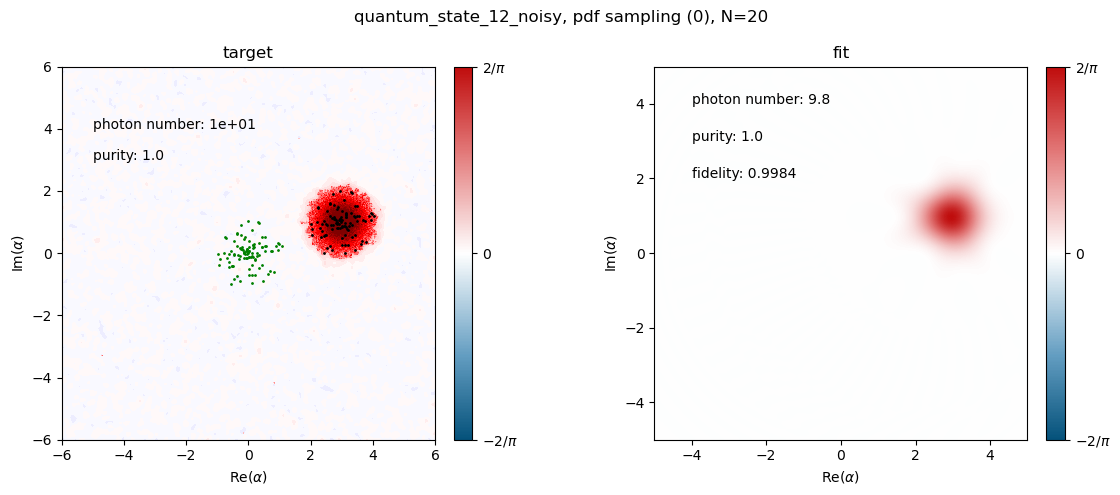

In [33]:
# PLOT RESULTS

title = "quantum_state_12_noisy, pdf sampling (0)"
# title = "noisy_state_12, pdf sampling (0)"
# title = "experimental cat_minus, pdf sampling (0)"

fitted_state =dq.to_qutip(corrected_fitted_state)
# xvec, yvec, wigner = dq.wigner(fitted_state)

## If target state is known
fidelity = dq.fidelity(target_state, fitted_state)
number_op = dq.number(N)
number_op50 = dq.number(50)
target_photon_number = dq.expect(number_op50, target_state).real
fitted_photon_number = dq.expect(number_op50, fitted_state).real
target_purity = dq.trace(target_state@target_state).real
fitted_purity = dq.trace(fitted_state@fitted_state).real

alpha_xs = [a[0].item() for a in alpha_ks]
alpha_ys = [a[1].item() for a in alpha_ks]

centered_alpha_xs = [a[0].item() for a in centered_alpha_ks]
centered_alpha_ys = [a[1].item() for a in centered_alpha_ks]


fig, axs = plt.subplots(1, 2, figsize=(2*6,1*5))

levels = np.linspace(-2/np.pi, 2/np.pi, 100)
# im = axs[0].contourf(xvec, yvec, wigner, levels=levels, cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
# fig.colorbar(im)
dq.plot.wigner(target_state, ax=axs[0])

im = plot_wigner(x_grid, p_grid, w_values, axs[0])
# fig.colorbar(im)
axs[0].scatter(alpha_xs, alpha_ys, s=1, c='k', marker='o')
axs[0].scatter(centered_alpha_xs, centered_alpha_ys, s=1, c='g', marker='o')
axs[0].set_title("target")
axs[0].annotate(f"photon number: {target_photon_number:.2}", (-5,4))
axs[0].annotate(f"purity: {target_purity:.2}", (-5,3))


# im = axs[1].contourf(x_grid, p_grid, w_values, levels=levels, cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)

dq.plot.wigner(fitted_state, ax=axs[1])

axs[1].set_title("fit")
axs[1].annotate(f"photon number: {fitted_photon_number:.2}", (-4,4))
axs[1].annotate(f"purity: {fitted_purity:.2}", (-4,3))
axs[1].annotate(f"fidelity: {fidelity:.4}", (-4,2))


for ax in axs:
    ax.set_xlabel("Re($\\alpha$)")
    ax.set_ylabel("Im($\\alpha$)")

fig.suptitle(f"{title}, N={N}")
fig.tight_layout()
fig.savefig(f"plots/{title}.png")